In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output
import tensorflow as tf

## Data

In [2]:
from glob import glob
from pathlib import Path
import os
from xml.dom import minidom

In [3]:
# parse xml file
input_files = []
labels = []

xmldoc = minidom.parse('data/training.xml')
inputs_features = xmldoc.getElementsByTagName('srcimg')
labels_features = xmldoc.getElementsByTagName('labelimg')

for idx, _ in enumerate(inputs_features):
    # get paths
    input_path = inputs_features[idx].attributes["name"].value
    label_path = labels_features[idx].attributes["name"].value
    # check names
    assert os.path.basename(input_path.replace("\\", "/")), os.path.basename(label_path.replace("\\", "/"))
    # update storages
    input_files.append(os.path.join("data", input_path.replace("\\", "/")))
    labels.append(os.path.join("data", label_path.replace("\\", "/")))

# zip data
data_paths = list(zip(input_files, labels))

In [4]:
train_paths = [i for i in data_paths if "female03" not in i[0]]
test_paths = [i for i in data_paths if "female03" in i[0]]

print(len(train_paths), len(test_paths))

16056 501


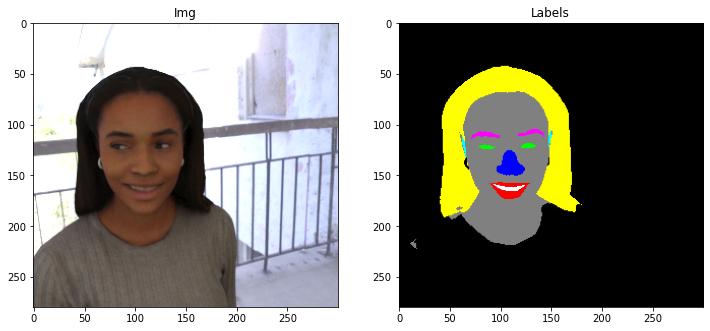

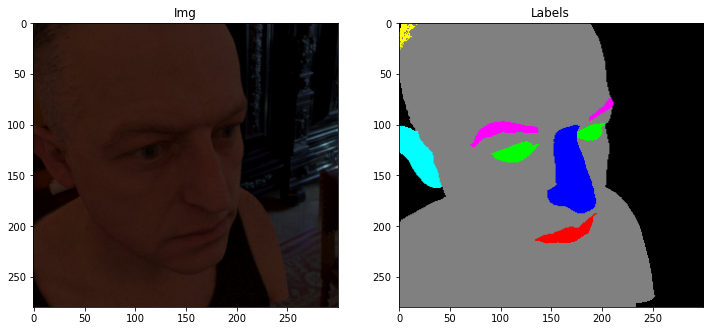

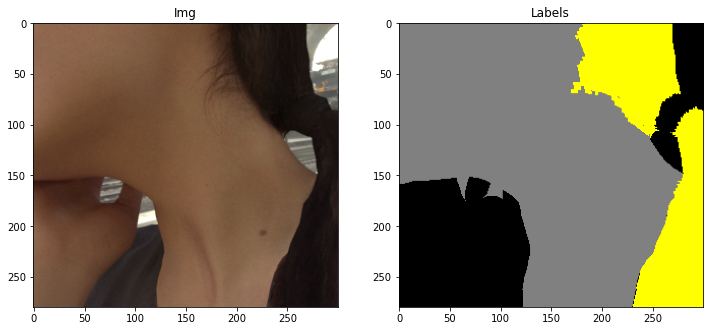

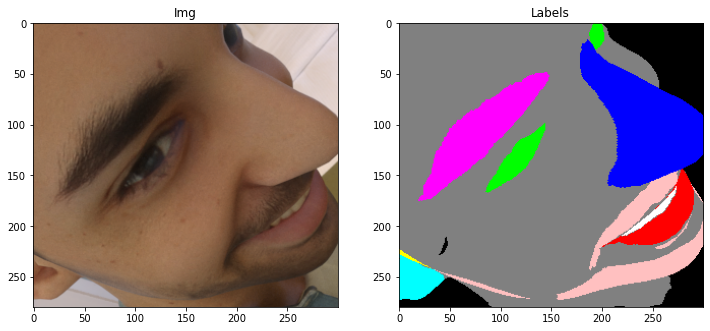

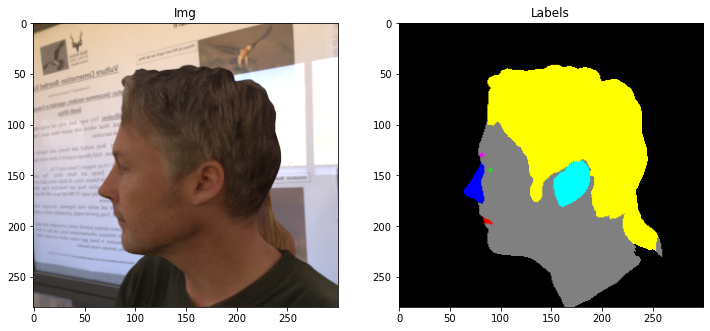

In [5]:
# show images
for _ in range(5):
    idx = np.random.choice(range(len(input_files)))
    img = cv2.imread(input_files[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = cv2.imread(labels[idx])
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
                           
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12,10))
    ax[0].imshow(img)
    ax[0].set_title("Img")
    ax[1].imshow(label)
    ax[1].set_title("Labels")
    plt.show()

In [6]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, data_paths: dict, batch_size=1, shuffle=False):
        self.data_paths = data_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(data_paths))
        # classes
        self.class2idx = {cl:idx for idx, cl in enumerate(CLASSES.keys(), start=1)}
        self.idx2class = {idx:cl for cl, idx in self.class2idx.items()}
        
        if self.shuffle:
            np.random.shuffle(data_paths)

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data_img = cv2.imread(self.data_paths[j][0])
            data_img = cv2.cvtColor(cv2.resize(data_img, (256, 256)), cv2.COLOR_BGR2RGB)
            data_img = (data_img.astype(np.float32) / 255).astype(np.float32)
            label_temp = cv2.imread(self.data_paths[j][1])
            label_temp = cv2.cvtColor(cv2.resize(label_temp, (256, 256)), cv2.COLOR_BGR2RGB)
            
            # update classes
#             label_img = np.expand_dims((np.sum(label_img, axis=-1) > 0).astype(np.float32), axis=-1)
            label_img = []

            for cl, vals in CLASSES.items():
                temp = np.zeros_like(label_temp)
                temp[(label_temp[..., 0]==vals[0]) & (label_temp[..., 1]==vals[1]) & (label_temp[..., 2]==vals[2])] = 1
                label_img.append(temp[..., 0])

            mask = np.stack(label_img, axis=-1).astype(np.float32)

            data.append([data_img, mask])
            
        
        # transpose list of lists
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

In [7]:
from sklearn.model_selection import train_test_split
CLASSES = {"background": [0,0,0],
           "lips": [255, 0, 0], "eye": [0,255,0], "nose": [0,0,255],"hair": [255, 255, 0],
            "brows":[255, 0, 255], "teeth": [255,255,255], "face": [128, 128, 128],
            "ears":[0,255,255], "glasses":[0,128,128], "beard":[255, 192, 192]}

train_paths, val_paths = train_test_split(data_paths, random_state=42)

In [8]:
train_dataloader = Dataloder(train_paths, batch_size=16, shuffle=True)
valid_dataloader = Dataloder(val_paths, batch_size=16, shuffle=True)

## Model

In [9]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [10]:
# load pretrained model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)
]
  
sm.set_framework('tf.keras')
model = sm.Unet(backbone_name='efficientnetb3', classes=len(CLASSES), activation="softmax")

dice_loss = sm.losses.DiceLoss(class_weights=[0.5,2,1,1,1,1,1,1,1,1,1])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(tf.keras.optimizers.Adam(0.001), loss=total_loss, 
              metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

2022-03-05 10:11:39.223974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:11:39.264459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:11:39.264594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:11:39.265329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
### %%time
# fit model
history = model.fit(train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=30,
                    validation_data=valid_dataloader,
                    validation_steps=len(valid_dataloader),
                    callbacks=callbacks)

Epoch 1/30


2022-03-05 10:11:50.761214: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-03-05 10:11:51.597418: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


776/776 [==============================] - 348s 430ms/step - loss: 0.3051 - iou_score: 0.5913 - f1-score: 0.6921 - val_loss: 0.1774 - val_iou_score: 0.6982 - val_f1-score: 0.8063 - lr: 0.0010
Epoch 2/30
776/776 [==============================] - 330s 425ms/step - loss: 0.1402 - iou_score: 0.7420 - f1-score: 0.8388 - val_loss: 0.1521 - val_iou_score: 0.7334 - val_f1-score: 0.8313 - lr: 0.0010
Epoch 3/30
776/776 [==============================] - 330s 426ms/step - loss: 0.1214 - iou_score: 0.7659 - f1-score: 0.8557 - val_loss: 0.1450 - val_iou_score: 0.7325 - val_f1-score: 0.8310 - lr: 0.0010
Epoch 4/30
776/776 [==============================] - 330s 425ms/step - loss: 0.1058 - iou_score: 0.7877 - f1-score: 0.8709 - val_loss: 0.1022 - val_iou_score: 0.7989 - val_f1-score: 0.8791 - lr: 0.0010
Epoch 5/30
776/776 [==============================] - 330s 425ms/step - loss: 0.0908 - iou_score: 0.8086 - f1-score: 0.8849 - val_loss: 0.1009 - val_iou_score: 0.8016 - val_f1-score: 0.8804 - lr: 0.0

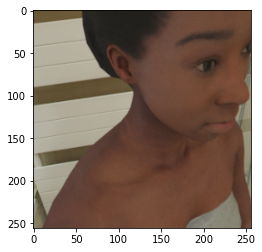

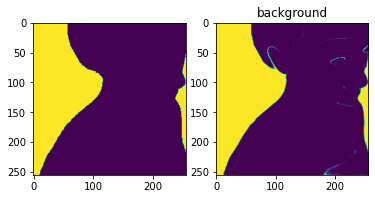

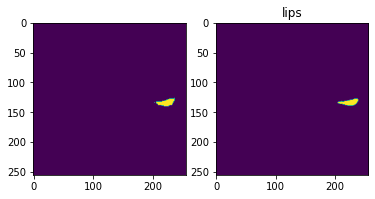

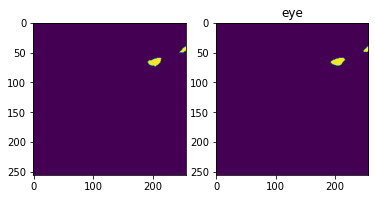

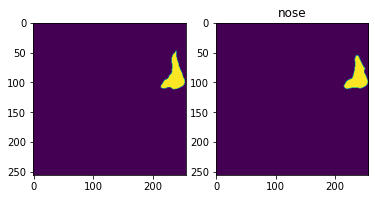

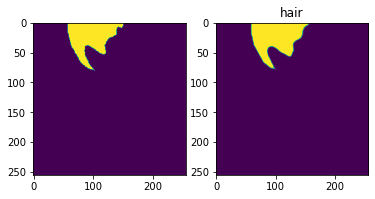

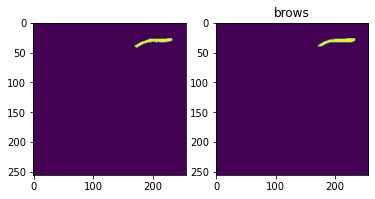

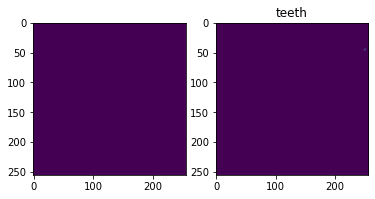

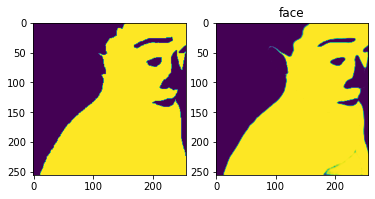

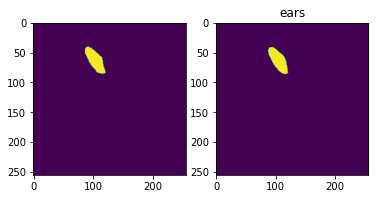

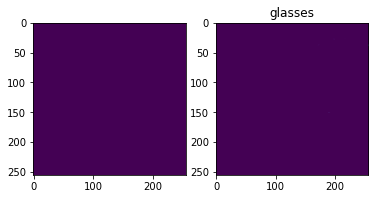

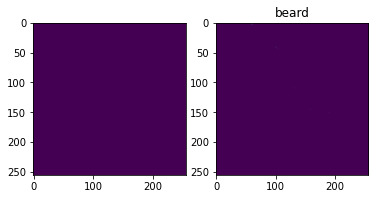

In [15]:
# DATA
for x, y in valid_dataloader:
    break
pred = model.predict(x)[5]

plt.imshow(x[5])
plt.show()

for i in range(11):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(y[5][..., i])
    ax[1].imshow(pred[..., i])
    plt.title(list(CLASSES.keys())[i])
    plt.show()

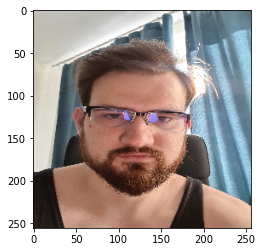

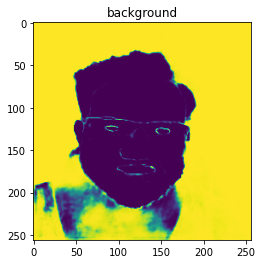

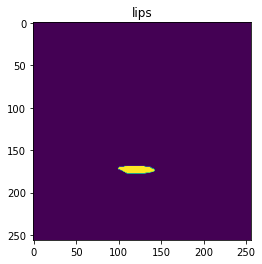

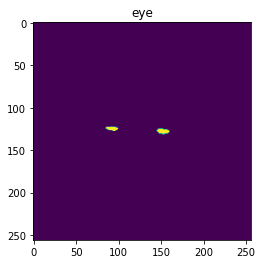

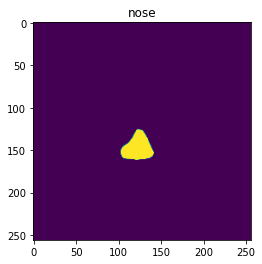

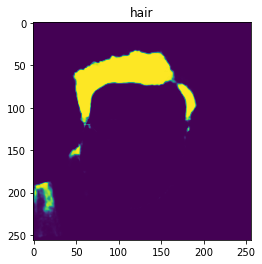

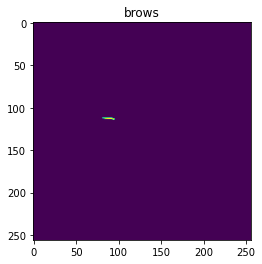

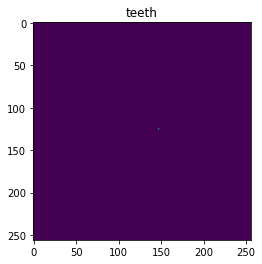

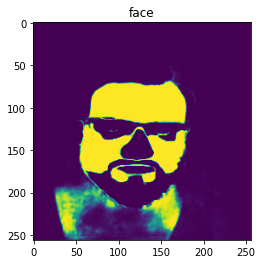

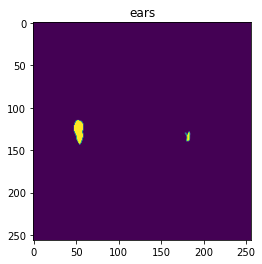

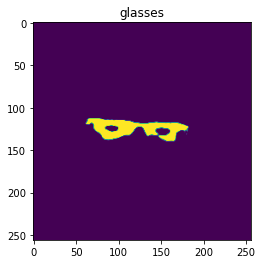

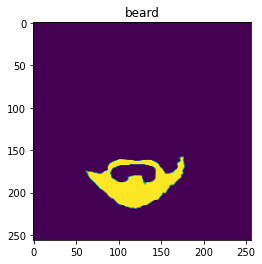

In [16]:
# ME
img = cv2.imread("me.jpg")
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
img = (img.astype(np.float32) / 255).astype(np.float32)

pred = model.predict(img)[0]

plt.imshow(img[0])
plt.show()

for i in range(11):
    plt.imshow(pred[..., i])
    plt.title(list(CLASSES.keys())[i])
    plt.show()